In [1]:
import torch
import torch.nn as nn
import os
import cv2
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
from torchvision import models
from torchvision import transforms
import os

In [3]:
if(os.path.split(os.getcwd())[1] == "Transfer_Learning" or os.path.split(os.getcwd())[1] == "semi-supervised" or os.path.split(os.getcwd())[1] == "self-supervised"):
    os.chdir("..")
print("Current Working Directory: {}".format(os.path.split(os.getcwd())[1]))

Current Working Directory: progettoVIPM


In [4]:
cuda=True

In [91]:
from utils.loadersAndEnums import datasets, ImageDataset
from torch.utils.data import DataLoader, ConcatDataset, random_split

trainL = ImageDataset(dataset=datasets.TRAINING_LABELED,network_input_size=256, cuda=cuda)
trainU = ImageDataset(dataset=datasets.TRAINING_UNLABELED,network_input_size=256, cuda=cuda)
trainC = ConcatDataset([trainL,trainU])
train_size = int(0.8*len(trainC))
val_size = len(trainC)-train_size
train,val = random_split(trainC,[train_size,val_size])
test = ImageDataset(dataset=datasets.TEST,network_input_size=256,cuda=cuda)


trainL = DataLoader(trainL,128,True)
train = DataLoader(train,128,True)
val = DataLoader(val,128,True)
test = DataLoader(test,128,True)

In [9]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  # (B, 64, H/2, W/2)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # (B, 128, H/4, W/4)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # (B, 256, H/8, W/8)
            nn.ReLU()
        )

    def forward(self, x):
        return self.encoder(x)


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 128, H/4, W/4)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 64, H/2, W/2)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 3, H, W)
            nn.Sigmoid()  # For normalized pixel values between 0 and 1
        )

    def forward(self, x):
        return self.decoder(x)
    
    


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

In [ ]:
autoencoder = Autoencoder()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 0.001)

train_loss = []
val_loss = []

num_epochs = 10
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}')
    autoencoder.train()
    running_loss = 0.0
    print('Training:')
    i = 0
    for inputs,_ in train:
        i = i+1
        if i%20 == 0:
            print(f'Batch {i} di {len(train)}')
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs,inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Train_Loss: {running_loss/len(train)}')
    train_loss.append(running_loss/len(train))
    autoencoder.eval()
    running_loss = 0.0
    print('Validation:')
    i = 0
    for inputs,_ in val:
        i = i+1
        if i%20 == 0:
            print(f'Batch {i} di {len(val)}')
        inputs = inputs.to(device)
        outputs = autoencoder(inputs)
        loss = criterion(outputs,inputs)
        running_loss += loss.item()
    print(f'Validation_Loss: {running_loss/len(val)}')
    val_loss.append(running_loss/len(val))

In [19]:
def plot_loss(train_loss,val_loss):
    fig, ax = plt.subplots()


    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Loss')
    ax.plot(train_loss, label='Training Loss')
    ax.plot(val_loss, label='Validation Loss')
    ax.legend()

    plt.show()

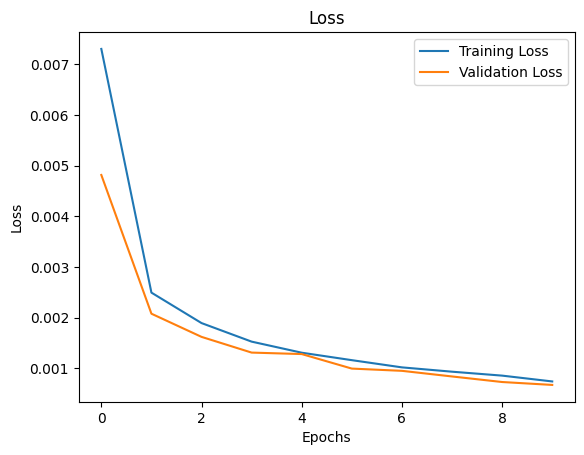

In [20]:
plot_loss(train_loss,val_loss)

In [21]:
encoder = autoencoder.encoder

In [77]:
batch = next(iter(train))
out = encoder(batch[0])
print(out.size())
out = out.view(out.size(0),-1)

torch.Size([128, 256, 32, 32])


In [78]:
print(out.size())

torch.Size([128, 262144])


In [1]:
class ExtendedEncoder(nn.Module):
    def __init__(self, base_encoder):
        super(ExtendedEncoder, self).__init__()
        self.base_encoder = base_encoder

        # Dynamically compute flatten_dim
        dummy_input = torch.randn(1, 3, 256, 256).to(device)  # Simulate input
        dummy_output = self.base_encoder(dummy_input)  # Get encoder output
        self.flatten_dim = dummy_output.view(1, -1).size(1)  # Flatten dimension
        
        # Fully connected layer
        self.fc = nn.Linear(self.flatten_dim, 251)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.base_encoder(x)  # Base encoder
        x = x.view(x.size(0),-1)  # Flatte
        x = self.fc(x)  # Fully connected layer
        x = self.softmax(x)
        return x

NameError: name 'nn' is not defined

In [110]:
torch.save(encoder, "SSEncoder.pth")

In [112]:
exEncoder = ExtendedEncoder(encoder)
exEncoder.to(device)
train_loss = []
val_loss = []
train_acc = []
val_acc = []
num_epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(exEncoder.parameters(), lr = 1e-5)
for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1}')
    exEncoder.train()
    running_loss = 0.0
    correct = 0
    total = 0
    i = 0
    print("Training:")
    for inputs, labels in trainL:
        i=i+1
        if i%10 == 0:
            print(f'Batch {i} di {len(trainL)}')
        labels = [int(label) for label in labels]
        
        inputs = inputs.to(device) 
        labels = torch.tensor(labels, dtype=torch.long).to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = exEncoder(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Training Loss: {running_loss/len(trainL)}, Accuracy: {100*correct/total}%')
    train_acc.append(100*correct/total)
    train_loss.append(running_loss/len(trainL))
    print('Validation:')
    exEncoder.eval()
    running_loss = 0.0
    i = 0
    with torch.no_grad():
        for inputs,lables in test:
            i+=1
            if i%10 == 0:
                print(f'Batch {i} di {len(test)}')            
            lables=[int(lable) for lable in lables]
            inputs,lables = inputs.to(device), torch.tensor(lables,dtype=torch.long).to(device)
            outputs = exEncoder(inputs)
            _,predicted = torch.max(outputs,1)
            total += lables.size(0)
            correct += (predicted == lables).sum().item()
            loss = criterion(outputs,lables)
            running_loss += loss.item()
    print(f'Validation Loss: {running_loss/len(test)}, Accuracy: {100*correct/total}%')
    val_loss.append(running_loss/len(test))
    val_acc.append(100*correct/total)
        
    
    

Epoch: 1
Training:
Batch 10 di 40
Batch 20 di 40
Batch 30 di 40
Batch 40 di 40
Training Loss: 5.527569890022278, Accuracy: 0.21912350597609562%
Validation:
Batch 10 di 94
Batch 20 di 94
Batch 30 di 94
Batch 40 di 94
Batch 50 di 94
Batch 60 di 94
Batch 70 di 94
Batch 80 di 94
Batch 90 di 94
Validation Loss: 5.52793620495086, Accuracy: 0.3702832961090866%
Epoch: 2
Training:
Batch 10 di 40
Batch 20 di 40
Batch 30 di 40
Batch 40 di 40
Training Loss: 5.528393745422363, Accuracy: 0.3784860557768924%
Validation:
Batch 10 di 94
Batch 20 di 94
Batch 30 di 94
Batch 40 di 94
Batch 50 di 94
Batch 60 di 94
Batch 70 di 94
Batch 80 di 94
Batch 90 di 94
Validation Loss: 5.527951986231702, Accuracy: 0.41730339720230397%
Epoch: 3
Training:
Batch 10 di 40
Batch 20 di 40
Batch 30 di 40
Batch 40 di 40
Training Loss: 5.528367507457733, Accuracy: 0.398406374501992%
Validation:
Batch 10 di 94
Batch 20 di 94
Batch 30 di 94
Batch 40 di 94
Batch 50 di 94
Batch 60 di 94
Batch 70 di 94
Batch 80 di 94
Batch 90 di 9

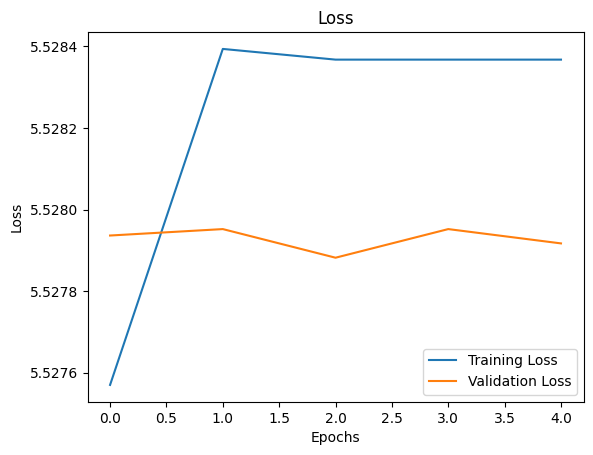

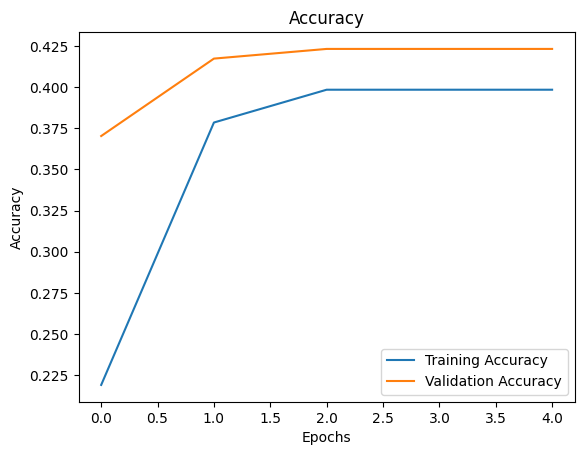

In [113]:
plot_loss(train_loss,val_loss)
def plot_accuracy(train_acc,val_acc):
    fig, ax = plt.subplots()


    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy')
    ax.plot(train_acc, label='Training Accuracy')
    ax.plot(val_acc, label='Validation Accuracy')
    ax.legend()

    plt.show()
plot_accuracy(train_acc,val_acc)

In [118]:
from sklearn.metrics import confusion_matrix, top_k_accuracy_score


all_preds = []
all_labels = []
all_out = []
exEncoder.eval()
with torch.no_grad():
    for inputs,labels in test:
        labels = [int(label) for label in labels]
        inputs, labels = inputs.to(device), torch.tensor(labels, dtype=torch.long).to(device)
        outputs = exEncoder(inputs)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_out.extend(outputs.cpu().numpy())
        
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_out = np.array(all_out)
cm = confusion_matrix(all_labels, all_preds)




In [122]:
correct = (all_preds==all_labels).sum().item()

print(f'Accuracy: {100 * correct / len(ImageDataset(dataset=datasets.TEST,network_input_size=256,cuda=cuda))}%')

Accuracy: 0.4335501083875271%


In [123]:
np.save("cmAutoEncoderModel10-5Epochs.npy",cm)
torch.save(exEncoder, "AutoEncoderModel.pth")